# Training - `misc-dia`

This notebook trains a Decoder-Only Transformer model to predict peptide retention times from sequence on `misc-dia` dataset.

---

## 1. Setup & Imports

In [11]:
import sys
sys.path.append('../src')

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTDecoderModel, split_dataset, collate, run_epoch, compute_metrics

import torch
from torch.utils.data import DataLoader

import random
import matplotlib.pyplot as plt

## 2. Configuration
Set data path, model hyperparameters, and training settings.

In [12]:
DATA_PATH = "../data/misc_dia.txt"
MODEL_PATH = "../models/misc_dia_decoder.pt"

# Model config
BATCH_SIZE = 256
EPOCHS = 300
LEARNING_RATE = 1e-3

# Parameters selected by HPO
D_MODEL = 192
N_HEADS = 4
N_LAYERS = 3
N_QUERIES = 20
DISABLE_SELF_ATTN = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda


## 3. Data Preparation
Load the dataset, split into train/validation, and create DataLoaders.

In [13]:
# Initialize tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)

# Split into train/val
train_ds, val_ds = split_dataset(dataset, val_ratio=0.05, seed=SEED)

# DataLoaders
coll = lambda b: collate(b, tokenizer.pad_id)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=coll)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=coll)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

Train samples: 139258, Val samples: 7329


## 4. Model Initialization
Create the Transformer model and optimizer.

In [14]:
model = PeptideRTDecoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS,
    n_queries=N_QUERIES,
    disable_self_attn=DISABLE_SELF_ATTN
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.SmoothL1Loss()

print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Model size: 1826882 parameters


## 5. Training Loop
Train the model and monitor loss.

In [15]:
train_losses, val_losses = [], []

#model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
best_val_loss = float("inf")
for epoch in range(0, EPOCHS):
    train_loss = run_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
    val_loss   = run_epoch(model, val_loader,   loss_fn, None, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    log_msg = f"Epoch {epoch:3d} | train loss {train_loss:.6f} | val loss {val_loss:.6f}"
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        log_msg += "  <-- best val loss so far, model saved"
    print(log_msg)

Epoch   0 | train loss 0.007119 | val loss 0.001415  <-- best val loss so far, model saved
Epoch   1 | train loss 0.001260 | val loss 0.000836  <-- best val loss so far, model saved
Epoch   2 | train loss 0.001091 | val loss 0.000772  <-- best val loss so far, model saved
Epoch   3 | train loss 0.000966 | val loss 0.000726  <-- best val loss so far, model saved
Epoch   4 | train loss 0.000855 | val loss 0.000673  <-- best val loss so far, model saved
Epoch   5 | train loss 0.000841 | val loss 0.000602  <-- best val loss so far, model saved
Epoch   6 | train loss 0.000787 | val loss 0.000573  <-- best val loss so far, model saved
Epoch   7 | train loss 0.000705 | val loss 0.000587
Epoch   8 | train loss 0.000666 | val loss 0.000654
Epoch   9 | train loss 0.000644 | val loss 0.000470  <-- best val loss so far, model saved
Epoch  10 | train loss 0.000617 | val loss 0.000522
Epoch  11 | train loss 0.000619 | val loss 0.000496
Epoch  12 | train loss 0.000617 | val loss 0.000488
Epoch  13 | 

## 6. Plot Training Curve

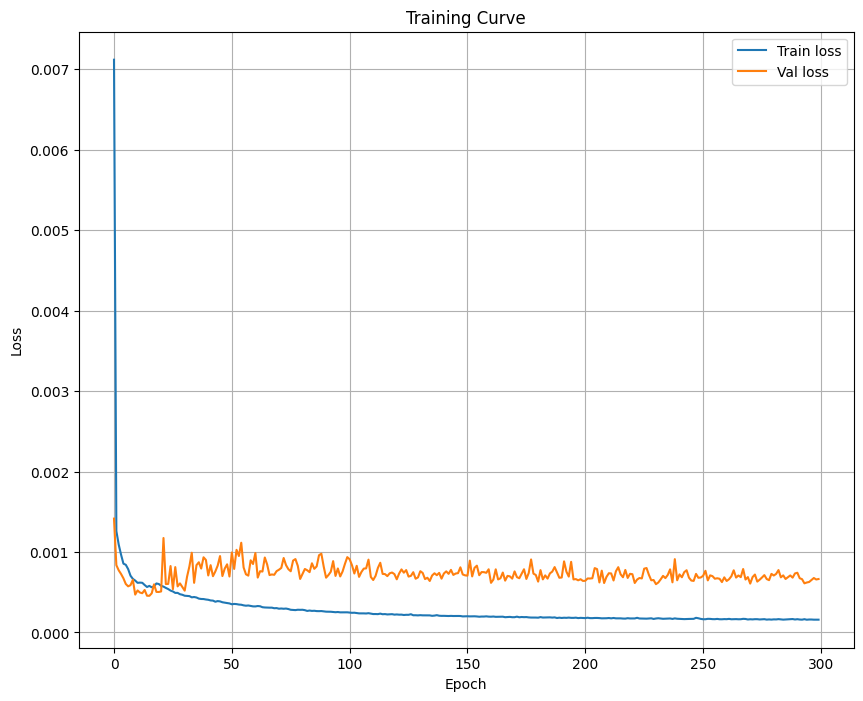

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve')
plt.grid(True)
plt.show()

## 7. Compute Main Metrics for Trained Model

In [17]:
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))

model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for seqs, mask, rts in val_loader:
        seqs, mask, rts = seqs.to(DEVICE), mask.to(DEVICE), rts.to(DEVICE)
        preds = model(seqs, mask)
        all_preds.append(preds.cpu())
        all_trues.append(rts.cpu())
all_preds = torch.cat(all_preds)
all_trues = torch.cat(all_trues)

metrics = compute_metrics(all_preds, all_trues)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.5f}")



Validation metrics for model:
MAE       : 0.02165
MSE       : 0.00091
RMSE      : 0.03016
Max_Abs_Error: 0.17483
Median_Abs_Error: 0.01557
Mean_Abs_Percentage_Error: 0.05314
Std_Error : 0.02978
Std_True  : 0.18900
Std_Pred  : 0.18486
R2        : 0.97453
Explained_Variance: 0.97517
Pearson   : 0.98755
Spearman  : 0.99038
